# LynxDataset tests

## Setup notebook and imports

For now, I tested everything in pytorch 2.0.1.

I had to install albumentations.

In [1]:
# Allow reloading of libraries without restarting the kernel
%load_ext autoreload
%autoreload 2

In [13]:
from dataset import LynxDataset
from pathlib import Path
dataset_csv = Path('/gpfsscratch/rech/ads/commun/datasets/extracted/lynx_dataset_full.csv')

## Accessing an element of the dataset

In [14]:
# Create an instance of the dataset
dataset = LynxDataset(dataset_csv=dataset_csv, loader="pil")

input, output = dataset[0]  # Example for getting the first item

# Accessing data
image = input['image']
lynx_id = output['lynx_id']
# Access other metadata from input as needed

## Iterating through the dataset

Using opencv as a loader, we encounter issues when loading some images.

Using pil with LOAD_TRUNCATED_IMAGES, we can circumvent this issue.

In [15]:
from tqdm import tqdm

corrupted_indices = []  # List to store indices of corrupted images

# Using tqdm to add a progress bar to the loop
for idx in tqdm(range(len(dataset)), desc="Processing dataset"):
    try:
        # Attempt to load the image data and other information
        input_dict, output_dict = dataset[idx]

        # Access key elements to ensure they're loaded correctly
        _ = input_dict['image']
        _ = output_dict['lynx_id']
        # Add checks for other elements if necessary

    except Exception as e:
        print(f"Error at index {idx}: {e}")
        corrupted_indices.append(idx)  # Append the index to the list
        continue

print("Dataset iteration completed with checks.")
print(f"Corrupted indices: {corrupted_indices}")

Processing dataset: 100%|██████████| 4466/4466 [05:24<00:00, 13.75it/s]

Dataset iteration completed with checks.
Corrupted indices: []


## Checking corrupted images

In [16]:
import matplotlib.pyplot as plt
from PIL import Image,ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def show_corrupted_images(dataset, corrupted_indices, num_images=5):
    """Function to display corrupted images."""
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i, idx in enumerate(corrupted_indices[:num_images]):
        try:
            # Load the image
            img = Image.open(dataset.dataframe.iloc[idx]['filepath'])
            axes[i].imshow(img)
            axes[i].set_title(f'Index: {idx}')
            axes[i].axis('off')
        except Exception as e:
            axes[i].set_title(f'Error at index {idx}')
            axes[i].axis('off')
            print(f"Error loading image at index {idx}: {e}")

    plt.tight_layout()
    plt.show()

# Call the function with your dataset and corrupted indices
show_corrupted_images(dataset, corrupted_indices, num_images=len(corrupted_indices))

ValueError: Number of columns must be a positive integer, not 0

<Figure size 1500x500 with 0 Axes>

(1984, 2576, 4)


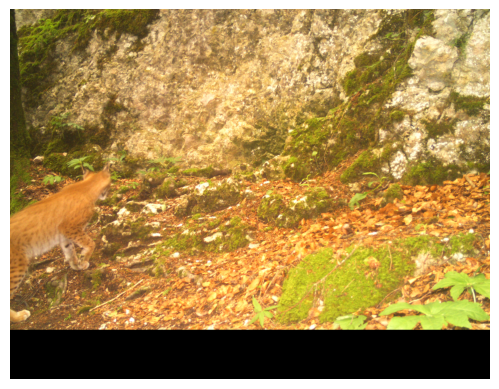

In [8]:
import numpy as np
import matplotlib.pyplot as plt

img = Image.open(dataset.dataframe.iloc[2031]['filepath'])
img = np.array(img)
print(img.shape) # Alpha channel

# This slices the image to only use the first three channels (RGB)
rgb_img = img[:, :, 0:3]

# Display the image
plt.imshow(rgb_img)
plt.axis('off')  # Turn off axis numbers and labels
plt.show()


## Comparing loading with pil vs opencv

In [7]:
import time
from PIL import Image,ImageFile

dataset_pil = LynxDataset(dataset_csv=dataset_csv, loader='pil')  # Use PIL
dataset_opencv = LynxDataset(dataset_csv=dataset_csv, loader='opencv')  # Use OpenCV

def measure_performance(dataset, num_samples=100):
    start_time = time.time()
    for i in range(num_samples):
        _ = dataset[i]
    end_time = time.time()
    return end_time - start_time

# Measure performance

_ = measure_performance(dataset_pil) #just for fairness, avoid cache difference...
pil_time = measure_performance(dataset_pil)
opencv_time = measure_performance(dataset_opencv)

print(f"Time taken with PIL: {pil_time} seconds")
print(f"Time taken with OpenCV: {opencv_time} seconds")

Time taken with PIL: 6.616126775741577 seconds
Time taken with OpenCV: 8.972260236740112 seconds


## Testing transformations

I splitted transformations in two parts : 
- transforms : systematic changes to images to bring them to the same format
- augmentations : random changes at each epoch to create artificial data


In [6]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define a standard resize transformation
standard_transform = A.Compose([
    A.Resize(224, 224),
])

#    ToTensorV2()


In [7]:
dataset = LynxDataset(dataset_csv=dataset_csv, loader="pil", transform = standard_transform)


(224, 224, 3)


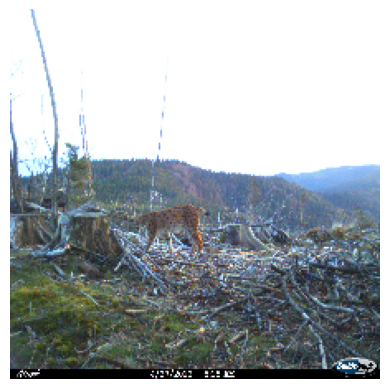

(224, 224, 3)


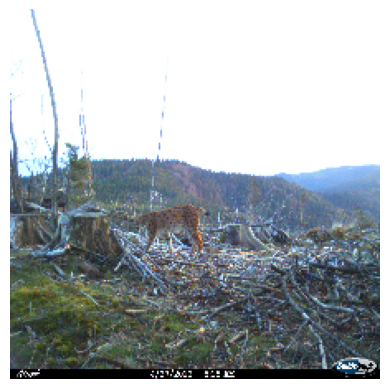

In [8]:
for i in range(5):
    print(dataset[0][0]['image'].shape)
    # Display the image
    plt.imshow(dataset[0][0]['image'])
    plt.axis('off')  # Turn off axis numbers and labels
    plt.show()

## Testing augmentations

Making sure that each time we get different changes each time we call a data.

In [16]:
import albumentations as A

augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=15, p=0.5),  # Small rotations
    A.CoarseDropout(max_holes=8, max_height=8, max_width=8, min_holes=1, fill_value=0, p=0.5),  # Coarse dropout
    # Add more augmentations as needed
])


In [17]:
dataset = LynxDataset(dataset_csv=dataset_csv, loader="pil", augmentation = augmentations)

(2000, 2592, 3)


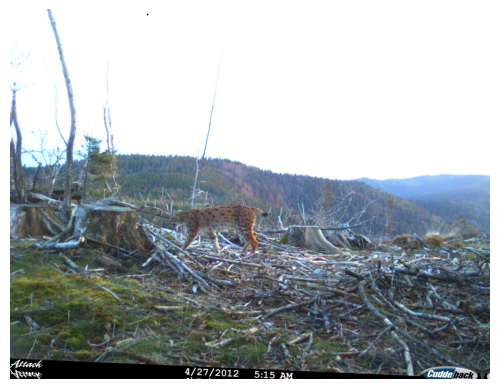

(2000, 2592, 3)


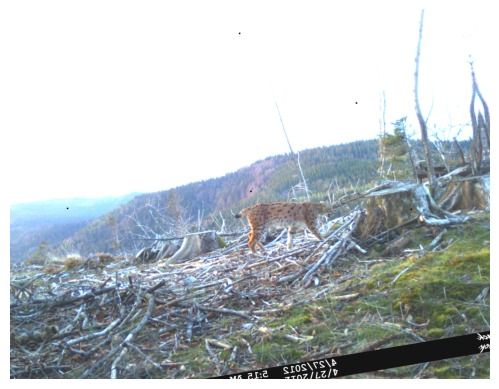

(2000, 2592, 3)


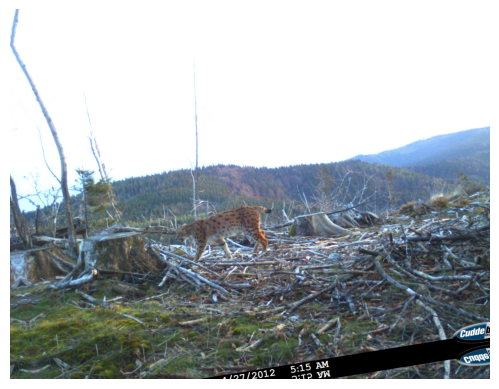

(2000, 2592, 3)


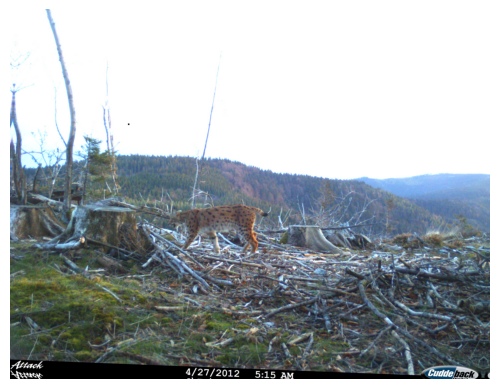

(2000, 2592, 3)


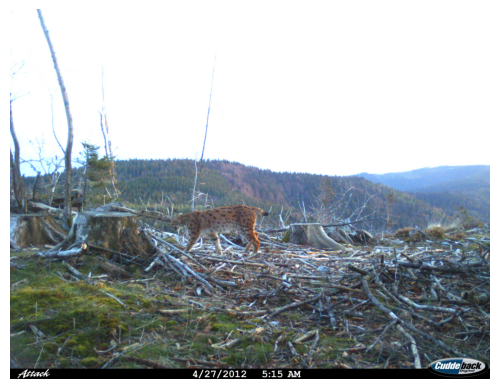

In [18]:
for i in range(5):
    print(dataset[0][0]['image'].shape)
    # Display the image
    plt.imshow(dataset[0][0]['image'])
    plt.axis('off')  # Turn off axis numbers and labels
    plt.show()

## Split pytorch dataset

This is just for checking the dataset is working properly.
Later on, we will have to do an equilibrated split on specific criterion...

In [ ]:
from torch.utils.data import Subset
from torch.utils.data.dataset import random_split

# Assume 'dataset' is your LynxDataset instance
dataset_size = len(dataset)
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15

# Calculate split sizes
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size

# Randomly split the dataset into train, validation, and test
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

print(f"Train set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_set)}")

## Split csv

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Load full dataset as a pandas DataFrame
full_dataset = pd.read_csv(dataset_csv)

# Split the dataset into train+val and test sets
train_val_set, test_set = train_test_split(full_dataset, test_size=0.2, random_state=42)

# Split the train+val set into train and validation sets
train_set, val_set = train_test_split(train_val_set, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Save these to .csv files in the same directory as the original dataset
train_set.to_csv(dataset_csv.parent / 'train_set.csv', index=False)
val_set.to_csv(dataset_csv.parent / 'val_set.csv', index=False)
test_set.to_csv(dataset_csv.parent / 'test_set.csv', index=False)

## Batch with Dataloader tests

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader

def my_collate(batch):
    # Initialize lists to gather all elements for each key
    images = []
    sources = []
    patterns = []
    dates = []
    locations = []
    image_numbers = []
    lynx_ids = []

    # Iterate over each item in the batch
    for input_dict, output_dict in batch:
        # Append data from input dictionary
        images.append(input_dict['image'])  # List of images
        sources.append(input_dict['source'])
        patterns.append(input_dict['pattern'])
        dates.append(input_dict['date'])
        locations.append(input_dict['location'])
        image_numbers.append(input_dict['image_number'])

        # Append data from output dictionary
        lynx_ids.append(output_dict['lynx_id'])

    # Construct the batched input and output dictionaries
    batched_input_dict = {
        'images': images,
        'sources': sources,
        'patterns': patterns,
        'dates': dates,
        'locations': locations,
        'image_numbers': image_numbers
    }

    batched_output_dict = {
        'lynx_ids': lynx_ids
    }

    return batched_input_dict, batched_output_dict


dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=my_collate)

#dataloader = DataLoader(dataset, batch_size=2, shuffle=False)


In [ ]:
next(enumerate(dataloader))

In [ ]:
# Iterate over the DataLoader
for batch in dataloader:
    inputs, outputs = batch